In [73]:
import pandas as pd
import numpy as np
import pprint
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [74]:
raw_data = [
    "Sunny\tHot\tHigh\tWeak\tNo",
    "Sunny\tHot\tHigh\tStrong\tNo",
    "Cloudy\tHot\tHigh\tWeak\tYes",
    "Rain\tMild\tHigh\tWeak\tYes",
    "Rain\tCool\tNormal\tWeak\tYes",
    "Rain\tCool\tNormal\tStrong\tNo",
    "Cloudy\tCool\tNormal\tStrong\tYes",
    "Sunny\tMild\tHigh\tWeak\tNo",
    "Sunny\tCool\tNormal\tWeak\tYes",
    "Rain\tMild\tNormal\tWeak\tYes",
    "Sunny\tMild\tNormal\tStrong\tYes",
    "Cloudy\tMild\tHigh\tStrong\tYes",
    "Cloudy\tHot\tNormal\tWeak\tYes",
    "Rain\tMild\tHigh\tStrong\tNo"
]

In [75]:
columns = ['Outlook', 'Temperature', 'Humidity', 'Wind', 'Play']
data_split = [row.split('\t') for row in raw_data]
df = pd.DataFrame(data_split, columns=columns)
print(df)

   Outlook Temperature Humidity    Wind Play
0    Sunny         Hot     High    Weak   No
1    Sunny         Hot     High  Strong   No
2   Cloudy         Hot     High    Weak  Yes
3     Rain        Mild     High    Weak  Yes
4     Rain        Cool   Normal    Weak  Yes
5     Rain        Cool   Normal  Strong   No
6   Cloudy        Cool   Normal  Strong  Yes
7    Sunny        Mild     High    Weak   No
8    Sunny        Cool   Normal    Weak  Yes
9     Rain        Mild   Normal    Weak  Yes
10   Sunny        Mild   Normal  Strong  Yes
11  Cloudy        Mild     High  Strong  Yes
12  Cloudy         Hot   Normal    Weak  Yes
13    Rain        Mild     High  Strong   No


In [76]:
def calculate_entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

In [77]:
def calculate_info_gain(data, split_attribute_name, target_name="Play"):
    total_entropy = calculate_entropy(data[target_name])
    
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)
    weighted_entropy = 0
    for i in range(len(vals)):
        subset = data[data[split_attribute_name] == vals[i]]
        weighted_entropy += (counts[i]/np.sum(counts)) * calculate_entropy(subset[target_name])
    
    # Information Gain formula
    gain = total_entropy - weighted_entropy
    print(f"   Feature: {split_attribute_name:12} | Info Gain: {gain:.4f}")
    return gain

In [78]:
def id3(data, original_data, features, target_attribute_name="Play"):
    # Base Case: All targets are the same (Pure leaf)
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    # Base Case: No more features to split on
    elif len(features) == 0:
        return original_data[target_attribute_name].mode()[0]
    
    else:
        current_entropy = calculate_entropy(data[target_attribute_name])
        print(f"\n--- Decision Node Split ---")
        print(f"Current Node Entropy: {current_entropy:.4f}")
        
        # Calculate Gain for all remaining features
        item_values = [calculate_info_gain(data, feature, target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        print(f"** SELECTED ROOT: {best_feature} (Gain: {item_values[best_feature_index]:.4f}) **")
        
        tree = {best_feature: {}}
        remaining_features = [i for i in features if i != best_feature]
        
        # Recurse for each unique value in the selected feature
        for value in np.unique(data[best_feature]):
            sub_data = data[data[best_feature] == value]
            subtree = id3(sub_data, original_data, remaining_features, target_attribute_name)
            tree[best_feature][value] = subtree
            
        return tree

In [79]:
features = ["Outlook", "Temperature", "Humidity", "Wind"]
tree = id3(df, df, features)
pprint.pprint(tree)


--- Decision Node Split ---
Current Node Entropy: 0.9403
   Feature: Outlook      | Info Gain: 0.2467
   Feature: Temperature  | Info Gain: 0.0292
   Feature: Humidity     | Info Gain: 0.1518
   Feature: Wind         | Info Gain: 0.0481
** SELECTED ROOT: Outlook (Gain: 0.2467) **

--- Decision Node Split ---
Current Node Entropy: 0.9710
   Feature: Temperature  | Info Gain: 0.0200
   Feature: Humidity     | Info Gain: 0.0200
   Feature: Wind         | Info Gain: 0.9710
** SELECTED ROOT: Wind (Gain: 0.9710) **

--- Decision Node Split ---
Current Node Entropy: 0.9710
   Feature: Temperature  | Info Gain: 0.5710
   Feature: Humidity     | Info Gain: 0.9710
   Feature: Wind         | Info Gain: 0.0200
** SELECTED ROOT: Humidity (Gain: 0.9710) **
{'Outlook': {'Cloudy': 'Yes',
             'Rain': {'Wind': {'Strong': 'No', 'Weak': 'Yes'}},
             'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}}}


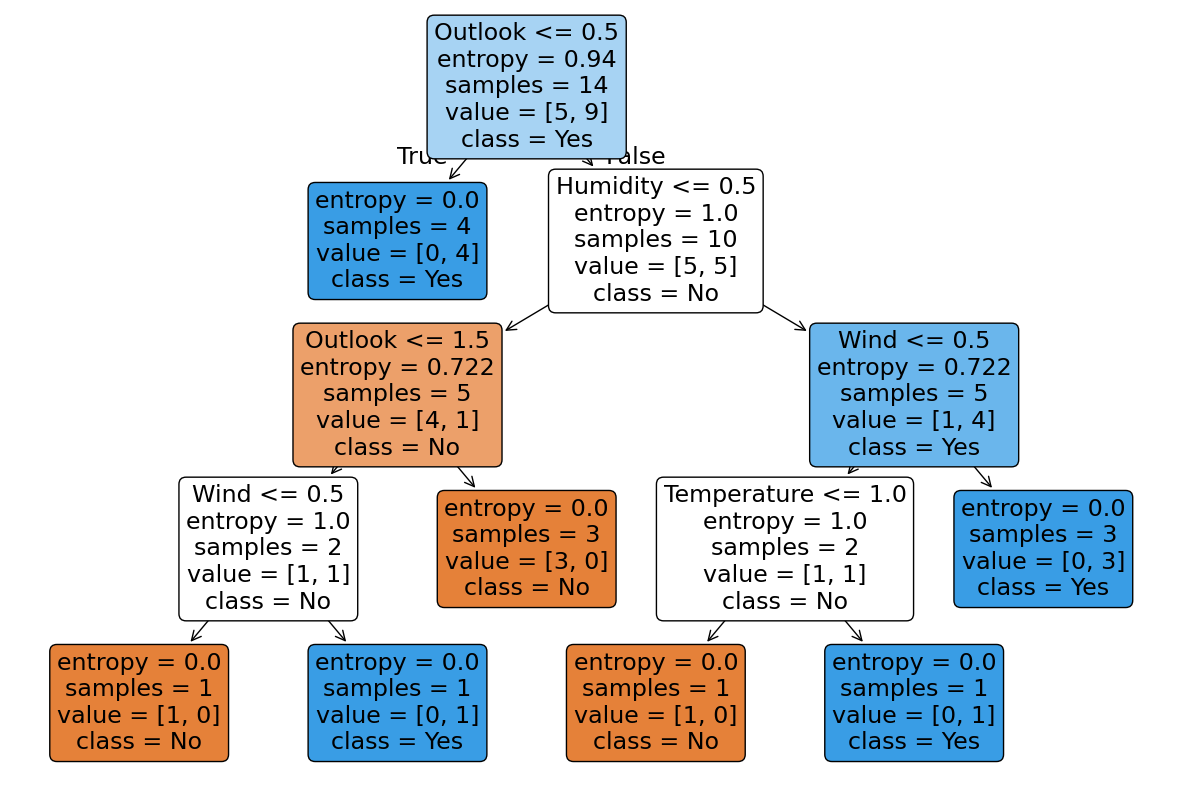

In [81]:
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

X = df_encoded.drop('Play', axis=1)
y = df_encoded['Play']

# 3. Train the model using Entropy (ID3 logic)
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X, y)

# 4. Visualize the tree (Your code)
plt.figure(figsize=(15,10))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    filled=True,
    rounded=True
)
plt.show()